In [2]:
# 1️. Imports & path setup
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Try XGBoost
try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except ImportError:
    HAS_XGB = False
    print("[WARN] xgboost not installed → XGBRegressor skipped. pip install xgboost")

BASE_DIR = Path("D:/Disertatie/1.database_performance_analysis").resolve()
FIG_ML_DIR = BASE_DIR / "results" / "figures" / "ml"
TABLES_DIR = BASE_DIR / "results" / "tables"

for p in [FIG_ML_DIR, TABLES_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# 2️ Load data și verifică coloanele disponibile
merged_path = TABLES_DIR / "diff_per_query_index.csv"

if merged_path.exists():
    df = pd.read_csv(merged_path)
    df["query_id"] = df["query_id"].astype(str)
    print(f"[INFO] Loaded data from: {merged_path}")
else:
    # Fallback: recreate quickly from raw CSVs
    print("[INFO] Creating merged dataset from raw files...")
    RAW_DIR = BASE_DIR / "data" / "raw"
    
    try:
        idx = pd.read_csv(RAW_DIR / "queries_with_index.csv")
        no = pd.read_csv(RAW_DIR / "queries_no_index.csv")
        
        # Rename execution time columns
        idx = idx.rename(columns={"execution_time_ms": "exec_time_index"})
        no = no.rename(columns={"execution_time_ms": "exec_time_no_index"})
        
        # Convert query_id to string
        idx["query_id"] = idx["query_id"].astype(str)
        no["query_id"] = no["query_id"].astype(str)
        
        # Merge datasets
        df = idx.merge(no, on="query_id", suffixes=("_idx", "_no"))
        
        print(f"[INFO] Created merged dataset with {df.shape[0]} rows, {df.shape[1]} columns")
        
    except FileNotFoundError as e:
        print(f"[ERROR] Could not find raw CSV files: {e}")
        raise


[WARN] xgboost not installed → XGBRegressor skipped. pip install xgboost
[INFO] Loaded data from: D:\Disertatie\1.database_performance_analysis\results\tables\diff_per_query_index.csv


In [3]:
# 3️ Explorează coloanele disponibile
print(f"\n Dataset Info:")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# Identifică coloanele numerice disponibile
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print(f"Numeric columns: {numeric_cols}")


 Dataset Info:
Shape: (122, 7)
Columns: ['query_id', 'documents_returned_x', 'exec_time_index', 'documents_returned_y', 'exec_time_no_index', 'diff_ms', 'pct_impr']
Numeric columns: ['documents_returned_x', 'exec_time_index', 'documents_returned_y', 'exec_time_no_index', 'diff_ms', 'pct_impr']


In [4]:
# 4️ Definește features bazate pe coloanele disponibile
available_features = []

# Check what columns we actually have
possible_features = [
    "documents_returned", 
    "documents_returned_idx", 
    "documents_returned_no",
    "exec_time_no_index",
    "time_saved_ms",
    "pct_improvement"
]

for feature in possible_features:
    if feature in df.columns:
        available_features.append(feature)

# If we still don't have enough features, use all numeric columns except target
if len(available_features) < 2:
    target_cols = ["exec_time_index"]
    available_features = [col for col in numeric_cols if col not in target_cols]

print(f"Available features for ML: {available_features}")

# Verifică dacă avem suficiente date pentru ML
if len(available_features) == 0:
    print("[ERROR] No suitable features found for ML modeling!")
    print("Available columns:", df.columns.tolist())
else:
    # 5️ Prepare data for ML
    X = df[available_features]
    y = df["exec_time_index"]  # target variable
    
    # Remove rows with missing values
    mask = ~(X.isna().any(axis=1) | y.isna())
    X_clean = X[mask]
    y_clean = y[mask]
    
    print(f"\n ML Setup:")
    print(f"Features: {available_features}")
    print(f"Target: exec_time_index")
    print(f"Clean samples: {len(X_clean)} / {len(df)} ({len(X_clean)/len(df)*100:.1f}%)")

       # 6️ Define models and cross-validation
# rmse_scorer = make_scorer(lambda y_true, y_pred: mean_squared_error(y_true, y_pred, squared=False), greater_is_better=False)
# cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
# models = {
#         "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
#     }

# Funcție RMSE compatibilă cu toate versiunile sklearn
def rmse_score(y_true, y_pred):
    """Calculează RMSE compatibil cu toate versiunile sklearn"""
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)

# Define scorers compatibili
rmse_scorer = make_scorer(rmse_score, greater_is_better=False)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
if HAS_XGB:
        models["XGBoost"] = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    
results = []
    

Available features for ML: ['documents_returned_x', 'documents_returned_y', 'exec_time_no_index', 'diff_ms', 'pct_impr']

 ML Setup:
Features: ['documents_returned_x', 'documents_returned_y', 'exec_time_no_index', 'diff_ms', 'pct_impr']
Target: exec_time_index
Clean samples: 122 / 122 (100.0%)


 XGBoost nu este instalat - doar Random Forest va fi folosit
 Modele definite: ['Random Forest']
 Features folosite: ['documents_returned_x', 'documents_returned_y', 'exec_time_no_index', 'diff_ms', 'pct_impr']
 Target: exec_time_index
 Samples pentru training: 122

 Training Random Forest...
  RMSE: 10.55 ± 3.73
  R²:   0.878 ± 0.083


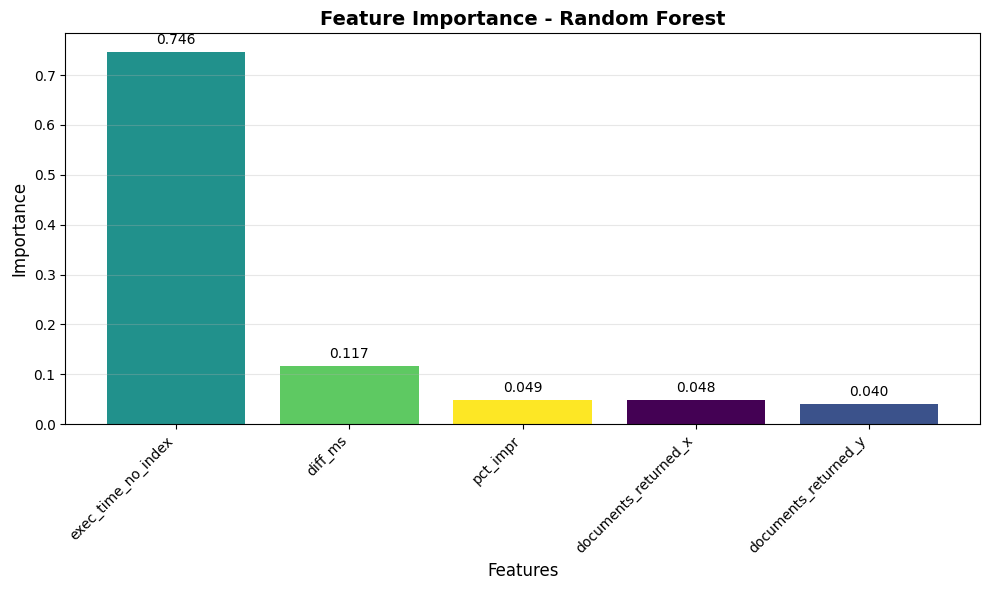


 Feature Importance (Random Forest):
  exec_time_no_index: 0.746
  diff_ms: 0.117
  pct_impr: 0.049
  documents_returned_x: 0.048
  documents_returned_y: 0.040

 Single-fold metrics (Random Forest):
  RMSE: 3.69
  R²: 0.988
  MAE: 1.29

 Results saved to: D:\Disertatie\1.database_performance_analysis\results\tables\ml_cv_metrics.csv

 Final Cross-Validation Results:
           Model  RMSE_mean  RMSE_std  R2_mean  R2_std
0  Random Forest    10.5484    3.7317   0.8779  0.0834

 Dataset Summary:
  Total samples: 122
  Clean samples used: 122
  Features used: 5
  Target variable range: 6.00 - 161.00
  Target variable mean: 65.31
  Target variable std: 33.91

 Feature summary saved to: D:\Disertatie\1.database_performance_analysis\results\tables\features_summary.csv


In [5]:
# Funcție RMSE compatibilă cu toate versiunile sklearn
def rmse_score(y_true, y_pred):
    """Calculează RMSE compatibil cu toate versiunile sklearn"""
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse)

# Define scorers și cross-validation
rmse_scorer = make_scorer(rmse_score, greater_is_better=False)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# 6️ Definește modelele
models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}

# Verifică dacă XGBoost este disponibil
try:
    from xgboost import XGBRegressor
    models["XGBoost"] = XGBRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    print(" XGBoost disponibil și adăugat")
except ImportError:
    print(" XGBoost nu este instalat - doar Random Forest va fi folosit")

# Inițializează lista pentru rezultate
results = []

print(f" Modele definite: {list(models.keys())}")
print(f" Features folosite: {available_features}")
print(f" Target: exec_time_index")
print(f" Samples pentru training: {len(X_clean)}")

# 7️ Train and evaluate models - VERSIUNE CORECTATĂ
for name, model in models.items():
    print(f"\n Training {name}...")
    
    # Cross-validation scores
    rmse_scores = -cross_val_score(model, X_clean, y_clean, cv=cv, scoring=rmse_scorer)
    r2_scores = cross_val_score(model, X_clean, y_clean, cv=cv, scoring='r2')
    
    # Store results
    results.append({
        'Model': name,
        'RMSE_mean': rmse_scores.mean(),
        'RMSE_std': rmse_scores.std(),
        'R2_mean': r2_scores.mean(),
        'R2_std': r2_scores.std()
    })
    
    print(f"  RMSE: {rmse_scores.mean():.2f} ± {rmse_scores.std():.2f}")
    print(f"  R²:   {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
    
    # Fit model for feature importance
    model.fit(X_clean, y_clean)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        # Create color palette
        colors = plt.cm.viridis(np.linspace(0, 1, len(importances)))
        
        plt.bar(range(len(importances)), importances[indices], color=colors[indices])
        plt.title(f'Feature Importance - {name}', fontsize=14, fontweight='bold')
        plt.xlabel('Features', fontsize=12)
        plt.ylabel('Importance', fontsize=12)
        plt.xticks(range(len(importances)), 
                   [available_features[i] for i in indices], 
                   rotation=45, ha='right')
        
        # Add value labels on bars
        for i, v in enumerate(importances[indices]):
            plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=10)
        
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        
        # Save plot
        filename = f"feature_importance_{name.lower().replace(' ', '_')}.png"
        plt.savefig(FIG_ML_DIR / filename, dpi=300, bbox_inches='tight')
        plt.show()
        
        # Print feature importance
        print(f"\n Feature Importance ({name}):")
        for i in indices:
            print(f"  {available_features[i]}: {importances[i]:.3f}")
    
    # Additional metrics calculation
    y_pred = model.predict(X_clean)
    
    # Manual RMSE calculation
    manual_rmse = np.sqrt(mean_squared_error(y_clean, y_pred))
    manual_r2 = r2_score(y_clean, y_pred)
    
    print(f"\n Single-fold metrics ({name}):")
    print(f"  RMSE: {manual_rmse:.2f}")
    print(f"  R²: {manual_r2:.3f}")
    print(f"  MAE: {np.mean(np.abs(y_clean - y_pred)):.2f}")

# 8️ Save results și statistici suplimentare
results_df = pd.DataFrame(results)
results_path = TABLES_DIR / "ml_cv_metrics.csv"
results_df.to_csv(results_path, index=False)

print(f"\n Results saved to: {results_path}")
print("\n Final Cross-Validation Results:")
print(results_df.round(4))

# Plot comparison of models (dacă ai mai multe modele)
if len(results) > 1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # RMSE comparison
    models_names = results_df['Model']
    rmse_means = results_df['RMSE_mean']
    rmse_stds = results_df['RMSE_std']
    
    ax1.bar(models_names, rmse_means, yerr=rmse_stds, capsize=5, alpha=0.7)
    ax1.set_title('RMSE Comparison (Lower is Better)')
    ax1.set_ylabel('RMSE')
    ax1.tick_params(axis='x', rotation=45)
    
    # R² comparison
    r2_means = results_df['R2_mean']
    r2_stds = results_df['R2_std']
    
    ax2.bar(models_names, r2_means, yerr=r2_stds, capsize=5, alpha=0.7, color='orange')
    ax2.set_title('R² Comparison (Higher is Better)')
    ax2.set_ylabel('R²')
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig(FIG_ML_DIR / "models_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

# Summary statistics
print(f"\n Dataset Summary:")
print(f"  Total samples: {len(df)}")
print(f"  Clean samples used: {len(X_clean)}")
print(f"  Features used: {len(available_features)}")
print(f"  Target variable range: {y_clean.min():.2f} - {y_clean.max():.2f}")
print(f"  Target variable mean: {y_clean.mean():.2f}")
print(f"  Target variable std: {y_clean.std():.2f}")

# Salvează și un summary al feature-urilor
feature_summary = pd.DataFrame({
    'Feature': available_features,
    'Mean': X_clean.mean(),
    'Std': X_clean.std(),
    'Min': X_clean.min(),
    'Max': X_clean.max()
})

feature_summary_path = TABLES_DIR / "features_summary.csv"
feature_summary.to_csv(feature_summary_path, index=False)
print(f"\n Feature summary saved to: {feature_summary_path}")

In [7]:
# 8️ Save results și statistici suplimentare
results_df = pd.DataFrame(results)
results_path = TABLES_DIR / "ml_cv_metrics.csv"
results_df.to_csv(results_path, index=False)

print(f"\n Results saved to: {results_path}")
print("\n Final Cross-Validation Results:")
print(results_df.round(4))

# Plot comparison of models
if len(results) > 1:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # RMSE comparison
    models_names = results_df['Model']
    rmse_means = results_df['RMSE_mean']
    rmse_stds = results_df['RMSE_std']
    
    ax1.bar(models_names, rmse_means, yerr=rmse_stds, capsize=5, alpha=0.7)
    ax1.set_title('RMSE Comparison (Lower is Better)')
    ax1.set_ylabel('RMSE')
    ax1.tick_params(axis='x', rotation=45)
    
    # R² comparison
    r2_means = results_df['R2_mean']
    r2_stds = results_df['R2_std']
    
    ax2.bar(models_names, r2_means, yerr=r2_stds, capsize=5, alpha=0.7, color='orange')
    ax2.set_title('R² Comparison (Higher is Better)')
    ax2.set_ylabel('R²')
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.savefig(FIG_ML_DIR / "models_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

# Summary statistics
print(f"\n Dataset Summary:")
print(f"  Total samples: {len(df)}")
print(f"  Clean samples used: {len(X_clean)}")
print(f"  Features used: {len(available_features)}")
print(f"  Target variable range: {y_clean.min():.2f} - {y_clean.max():.2f}")
print(f"  Target variable mean: {y_clean.mean():.2f}")
print(f"  Target variable std: {y_clean.std():.2f}")


 Results saved to: D:\Disertatie\1.database_performance_analysis\results\tables\ml_cv_metrics.csv

 Final Cross-Validation Results:
           Model  RMSE_mean  RMSE_std  R2_mean  R2_std
0  Random Forest    10.5484    3.7317   0.8779  0.0834

 Dataset Summary:
  Total samples: 122
  Clean samples used: 122
  Features used: 5
  Target variable range: 6.00 - 161.00
  Target variable mean: 65.31
  Target variable std: 33.91
